# Choose proper tutors for math exam
In this competition your task will be to predict the probability for a tutor to be a proper one for preparing for the math exam. You will be given two datasets: train.csv (contains all features and the target) and test.csv (only features).

### Примерный план:

1. EDA
2. Обработка данных (если требуется)
3. Построение моделей (выбор наиболее подходящей)
4. Настройка финальной модели
5. Анализ прогнозов модели

**imports**

In [288]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # использую только для бустинговых моделей

import random

**functions**

In [2]:
def corr_matrix(data, features):
    corr_matrix = np.round(data.loc[:, features].corr(), 2)
    corr_matrix[np.abs(corr_matrix) < 0.1] = 0
    
    plt.figure(figsize = (9,7))
    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

In [3]:
def calc_accuracy(pred, y):
    return sum(pred == y) / len(y)

In [4]:
def calc_logloss(y, y_pred):
    constrain = 1e-15
    y_pred = pd.Series(y_pred)
    y_pred[y_pred < constrain] = constrain
    y_pred[y_pred > 1 - constrain] = 1 - constrain
    y_pred = np.array(y_pred)

    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [5]:
def confusion_matrix(y, y_pred):
    tp = np.array(list(map(int, (y == 1)*(y_pred == 1)))).sum()
    fp = np.array(list(map(int, (y == 0)*(y_pred == 1)))).sum()
    fn = np.array(list(map(int, (y == 1)*(y_pred == 0)))).sum()
    tn = np.array(list(map(int, (y == 0)*(y_pred == 0)))).sum()
    conf_matrix = pd.DataFrame({'y=1': [tp, fn], 
                                'y=0': [fp, tn]},
                                index=['y_pred=1', 'y_pred=0'])
    return conf_matrix

In [6]:
def calc_precision(matrix):
    return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])

def calc_recall(matrix):
    return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=1'][1])

In [290]:
def find_best_param_sklearn(train_data, train_labels, test_data, test_labels, _range, target: str):
    
    train_acc = []
    test_acc = []
    train_logloss = []
    test_logloss = []
    
    train_precision = []
    test_precision = []
    train_recall = []
    test_recall = []

    
    for i in _range:
        if target == 'max_depth':
            tree = DecisionTreeClassifier(max_depth=i)
        elif target == 'min_leaf':
            tree = DecisionTreeClassifier(min_samples_leaf=i, max_depth=5)
#         elif target == 'impurity_weights':
#             tree = DecisionTreeRegressor(class_weight[i], min_leaf=15, max_depth=5)
        else:
            print('Oops. Wrong target parameter')
            
        print(f'{i}. Target: {target}. Tree params: {list(tree.__dict__.items())}')
        tree.fit(train_data, train_labels)
        
        train_preds = tree.predict(train_data)
        test_preds = tree.predict(test_data)
        
        train_acc.append(calc_accuracy(train_preds, train_labels))
        test_acc.append(calc_accuracy(test_preds, test_labels))
        
        train_logloss.append(0)
        test_logloss.append(0)
        
        train_conf_matrix = confusion_matrix(train_labels, train_preds)
        train_precision.append(calc_precision(train_conf_matrix))
        train_recall.append(calc_recall(train_conf_matrix))
        print(train_conf_matrix)
        
        test_conf_matrix = confusion_matrix(test_labels, test_preds)
        test_precision.append(calc_precision(test_conf_matrix))
        test_recall.append(calc_recall(test_conf_matrix))
        print(f'{test_conf_matrix}\n')
    
    return (train_acc, test_acc, train_logloss, test_logloss, train_precision, test_precision, train_recall, test_recall)

In [280]:
def find_best_param(impurity_weights: list, train_data, train_labels, test_data, test_labels, _range, target: str):
    
    train_acc = []
    test_acc = []
    train_logloss = []
    test_logloss = []
    
    train_precision = []
    test_precision = []
    train_recall = []
    test_recall = []

    
    for i in _range:
        if target == 'max_depth':
            tree = DTC(impurity_weights, max_depth=i)
        elif target == 'min_leaf':
            tree = DTC(impurity_weights, min_leaf=i, max_depth=5)
        elif target == 'impurity_weights':
            tree = DTC(impurity_weights[i], min_leaf=15, max_depth=5)
        else:
            print('Oops. Wrong target parameter')
            
        print(f'{i}. Target: {target}. Tree params: {list(tree.__dict__.items())}')
        tree.fit(train_data, train_labels)
        
        train_preds = tree.predict(train_data)
        test_preds = tree.predict(test_data)
        
        train_acc.append(calc_accuracy(train_preds, train_labels))
        test_acc.append(calc_accuracy(test_preds, test_labels))
        
        train_logloss.append(calc_logloss(train_labels, tree.predict_proba(train_data)))
        test_logloss.append(calc_logloss(test_labels, tree.predict_proba(test_data)))
        
        train_conf_matrix = confusion_matrix(train_labels, train_preds)
        train_precision.append(calc_precision(train_conf_matrix))
        train_recall.append(calc_recall(train_conf_matrix))
        print(train_conf_matrix)
        
        test_conf_matrix = confusion_matrix(test_labels, test_preds)
        test_precision.append(calc_precision(test_conf_matrix))
        test_recall.append(calc_recall(test_conf_matrix))
        print(f'{test_conf_matrix}\n')
    
    return (train_acc, test_acc, train_logloss, test_logloss, train_precision, test_precision, train_recall, test_recall)

In [75]:
def show_err_plots(_range, param_name, errors):
    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.plot(_range, errors[0])
    plt.plot(_range, errors[1])
    plt.xlabel(param_name)
    plt.ylabel('accuracy')

    plt.subplot(222)
    plt.plot(_range, errors[2])
    plt.plot(_range, errors[3])
    plt.xlabel(param_name)
    plt.ylabel('logloss')
    
    plt.subplot(223)
    plt.plot(_range, errors[4])
    plt.plot(_range, errors[5])
    plt.xlabel(param_name)
    plt.ylabel('precision')
    
    plt.subplot(224)
    plt.plot(_range, errors[6])
    plt.plot(_range, errors[7])
    plt.xlabel(param_name)
    plt.ylabel('recall')

    plt.show()

**models**

In [171]:
def qual(m_fir, m_sec, fir, sec, thir, four, mul1=1, mul2=1):
    total = fir + sec + thir + four
    left = fir + sec
    right = thir + four
    quality = gini(m_fir, m_sec, mul1, mul2) - \
                  ((left / total) * gini(fir, sec, mul1, mul2)) - \
                  ((right / total) * gini(thir, four, mul1, mul2))
    print(f'{((quality / gini(m_fir, m_sec, mul1, mul2)) * 100):.2f}%')
    return quality

In [228]:
def gini(fir, sec, mul1=1, mul2=1):
    total = fir + sec
    gini = ((mul1 * (fir / total)**2) + (mul2 * (sec / total)**2)) / (mul1 + mul2)
    impurity = 1 - gini
    print(f'Total labels: {total},\ngini: {gini:.4f},\ngini impurity: {impurity:.4f}\n')
    return impurity

In [229]:
qual(18, 2, 15, 1, 3, 1, 1, 1)

Total labels: 20,
gini: 0.4100,
gini impurity: 0.5900

Total labels: 16,
gini: 0.4414,
gini impurity: 0.5586

Total labels: 4,
gini: 0.3125,
gini impurity: 0.6875

Total labels: 20,
gini: 0.4100,
gini impurity: 0.5900

0.95%


0.005624999999999936

In [230]:
qual(18, 2, 15, 0, 3, 2, 1, 1)

Total labels: 20,
gini: 0.4100,
gini impurity: 0.5900

Total labels: 15,
gini: 0.5000,
gini impurity: 0.5000

Total labels: 5,
gini: 0.2600,
gini impurity: 0.7400

Total labels: 20,
gini: 0.4100,
gini impurity: 0.5900

5.08%


0.02999999999999997

In [262]:
random.seed(42)


class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:

    def __init__(self, data, labels, threshold):
        self.data = data
        self.labels = labels
        self.threshold = threshold
        self.prediction = self.predict()

#     def predict(self):
#         classes = {}
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
#         prediction = max(classes, key=classes.get)
#         probability = 0
#         if classes.get(1):
#             probability += classes.get(1) / sum(classes.values())
            
#         return prediction, probability
    
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        
        probability = 0
        if classes.get(1):
            probability += classes.get(1) / sum(classes.values())
            
        if probability >= self.threshold:
            prediction = 1
        else:
            prediction = 0
            
        return prediction, probability


class DTC:

    def __init__(self, impurity_weights, min_leaf: int = 5, max_depth: int = np.inf, threshold: float = 0.5):
#     def __init__(self, min_leaf: int = 5, max_depth: int = np.inf, threshold: float = 0.5):
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.threshold = threshold
        self.impurity_weights = impurity_weights
#         self.impurity_func = impurity_func (, impurity_func: str = 'gini')
        self._tree = None

    def _impurity_func(self, labels):

        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        
#         gini = sum([(((classes[label] / len(labels)) ** 2) * self.impurity_weights[label]) / (len(classes) * sum(self.impurity_weights)) for label in classes])
        gini = sum([((classes[label] * self.impurity_weights[label]) / (len(labels) * sum(self.impurity_weights))) ** 2 for label in classes])
#         impurity = 1
#         for label in classes:
#             p = classes[label] / len(labels)
#             impurity -= p ** 2
        return 1 - gini



#         if self.impurity_func == 'entropy':
#             impurity = 0
#             for label in classes:
#                 p = classes[label] / len(labels)
#                 impurity += p * np.log2(p)
#             return -impurity

#         else:  # gini
#             impurity = 1
#             for label in classes:
#                 p = classes[label] / len(labels)
#                 impurity -= p ** 2
#             return impurity

    def _quality(self, left_labels, right_labels, current_impurity):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_impurity - p * self._impurity_func(left_labels) - (1 - p) * self._impurity_func(right_labels)

    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def _find_best_split(self, data, labels):
        current_impurity = self._impurity_func(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_impurity)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def _build_tree(self, data, labels, depth_i=1):
        quality, t, index = self._find_best_split(data, labels)

        if quality == 0 or depth_i > self.max_depth:
            return Leaf(data, labels, self.threshold)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

        depth_i += 1
        true_branch = self._build_tree(true_data, true_labels, depth_i=depth_i)
        false_branch = self._build_tree(false_data, false_labels, depth_i=depth_i)

        return Node(index, t, true_branch, false_branch)
    
    def fit(self, data, labels):
        self._tree = self._build_tree(data, labels)
    
    def _classify_object(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction[0]
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)

    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._tree)
            classes.append(prediction)
        return np.array(classes)
    
    def _object_probability(self, obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction[1]
            return answer

        if obj[node.index] <= node.t:
            return self._object_probability(obj, node.true_branch)
        else:
            return self._object_probability(obj, node.false_branch)
    
    def predict_proba(self, data):
        probabilities = []
        for obj in data:
            prediction = self._object_probability(obj, self._tree)
            probabilities.append(prediction)
        return np.array(probabilities)

**paths**

In [11]:
TRAIN_DATA = './data/train.csv'
TEST_DATA = './data/test.csv'

# EDA

In [12]:
df = pd.read_csv(TRAIN_DATA)
df.head(2)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1


In [13]:
print(f'Размерность: {df.shape}\nКол-во пропущенных данных: {df.isna().sum().values.sum()}')

Размерность: (10000, 13)
Кол-во пропущенных данных: 0


In [14]:
NUM_FEATURES = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']
DUMMY_FEATURES = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']

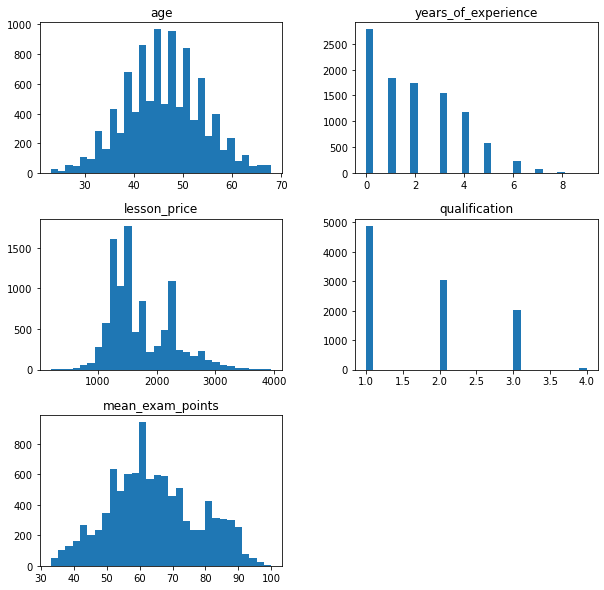

In [15]:
df.loc[:, NUM_FEATURES].hist(figsize=(10, 10), bins=30, grid=False);

In [16]:
desc_df = df.loc[:, NUM_FEATURES].describe().copy()
median = pd.DataFrame(df.loc[:, NUM_FEATURES].median()).T.set_index(pd.Index(['median']))
mode = pd.DataFrame(df.loc[:, NUM_FEATURES].mode()).set_index(pd.Index(['mode'])).copy()
desc_df.append([median, mode])

,age,years_of_experience,lesson_price,qualification,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.800900,1.974800,1702.440000,1.724300,64.435200
std,8.030274,1.766883,523.789062,0.798845,13.595024
min,23.000000,0.000000,200.000000,1.000000,33.000000
25%,40.000000,0.000000,1300.000000,1.000000,55.000000
50%,46.000000,2.000000,1550.000000,2.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,74.000000
max,68.000000,9.000000,3950.000000,4.000000,100.000000
median,46.000000,2.000000,1550.000000,2.000000,63.000000
mode,44.000000,0.000000,1450.000000,1.000000,62.000000


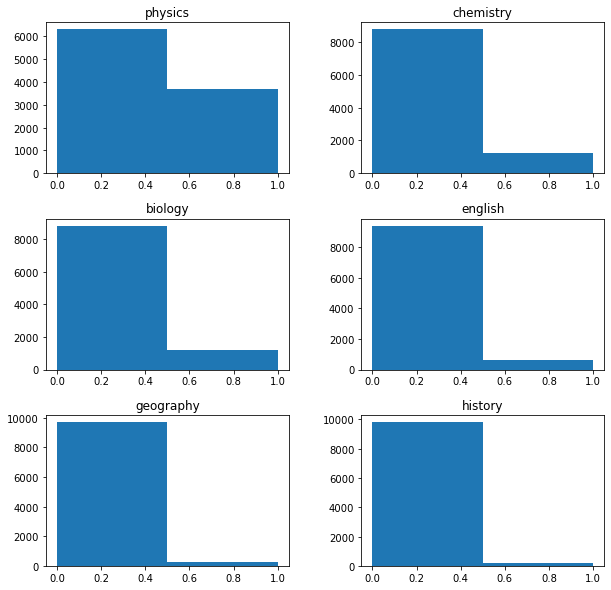

In [17]:
df.loc[:, DUMMY_FEATURES].hist(figsize=(10, 10), bins=2, grid=False);

In [18]:
df.loc[:, DUMMY_FEATURES].mean()

physics      0.3706
chemistry    0.1215
biology      0.1172
english      0.0591
geography    0.0277
history      0.0180
dtype: float64

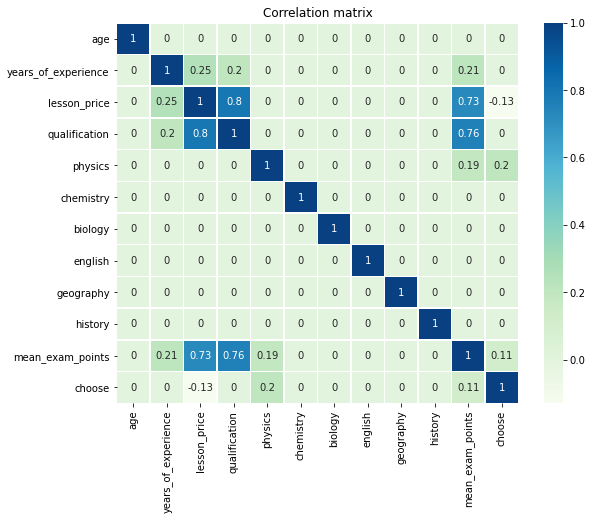

In [19]:
corr_matrix(df, df.columns[1:])

***
**Промежуточные выводы:**
- В данных нет NaN значений, сами данные очень красивые, возраст распределен нормально, в остальных фичах нет весомых выбросов
- На первый взгляд с таргетом ничего не коррелирует, заметно что немного на выбор преподавателя влиет его близость с физикой и средние баллы его учеников на экзамене 
- Так как у нас нет заметных линейных взаимосвязей между фичами и таргетом - будем кормить лес деревьев нашими данными, так как деревья хорошо ищут скрытые связи между фичами и таргетом
- Пока что не буду удалять фичи из датасета, вдруг деревья вытянут из них пользу
***

### Разбиваю данные на train/test

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(df.loc[:, 'age':'mean_exam_points'],
                                                                    df['choose'],
                                                                    test_size = 0.2,
                                                                    random_state=42)

train_data = train_data.to_numpy()
train_labels = train_labels.to_numpy()
test_data = test_data.to_numpy()
test_labels = test_labels.to_numpy()

In [21]:
calc_accuracy(np.zeros((8000,)), train_labels)

0.8915

***
**Проблема дисбаланса классов**:
- Сверху я создал массив ответов полностью из нулей
- Метрика accuracy, выдает на такой массив 89% точности
- Это значит, что  
 1) нельзя просто так использовать accuracy, как и logloss, так как они не репрезентативны при большом дисбалансе  
 2) можно попробовать разделить выборку так, чтобы кол-во классов в данных совпадало
 
***

In [22]:
from matplotlib.colors import ListedColormap

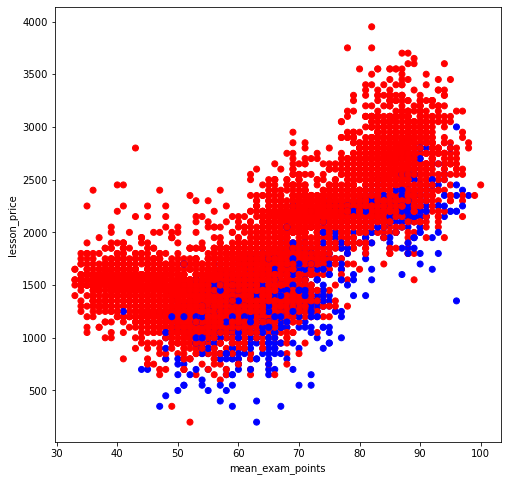

In [23]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(8, 8))
plt.scatter(df.loc[:, 'mean_exam_points'], df.loc[:, 'lesson_price'], c=df['choose'], cmap=cmap)
plt.xlabel('mean_exam_points')
plt.ylabel('lesson_price')
plt.show()

## Decision Tree Classificator

#### Подбор гиперпараметров max_depth / leaf_lim

0. Target: impurity_weights. Tree params: [('min_leaf', 15), ('max_depth', 5), ('threshold', 0.5), ('impurity_weights', [1, 1]), ('_tree', None)]
          y=1   y=0
y_pred=1   84    44
y_pred=0  784  7088
          y=1   y=0
y_pred=1   28    16
y_pred=0  213  1743

1. Target: impurity_weights. Tree params: [('min_leaf', 15), ('max_depth', 5), ('threshold', 0.5), ('impurity_weights', [1, 201]), ('_tree', None)]
          y=1   y=0
y_pred=1   84    44
y_pred=0  784  7088
          y=1   y=0
y_pred=1   28    16
y_pred=0  213  1743

2. Target: impurity_weights. Tree params: [('min_leaf', 15), ('max_depth', 5), ('threshold', 0.5), ('impurity_weights', [1, 401]), ('_tree', None)]
          y=1   y=0
y_pred=1   84    44
y_pred=0  784  7088
          y=1   y=0
y_pred=1   28    16
y_pred=0  213  1743

3. Target: impurity_weights. Tree params: [('min_leaf', 15), ('max_depth', 5), ('threshold', 0.5), ('impurity_weights', [1, 601]), ('_tree', None)]
          y=1   y=0
y_pred=1   84    44
y_pred=

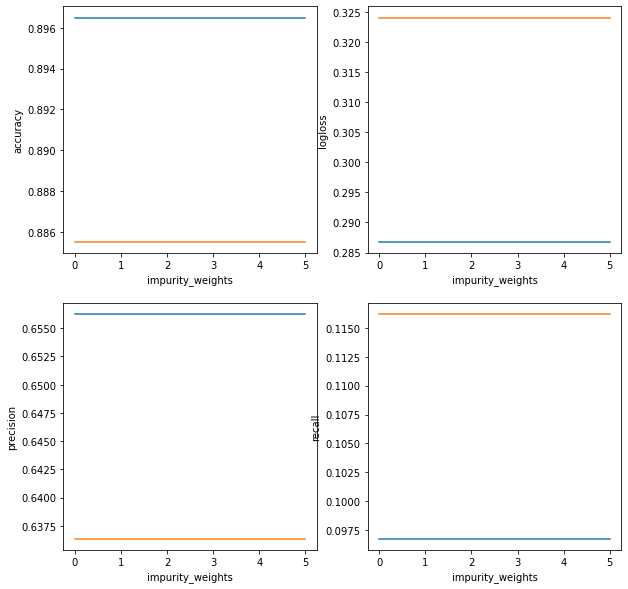

In [277]:
impurity_weights = [[1, el] for el in np.arange(1, 1100, 200)]
_range = range(6)
target = 'impurity_weights'

errors = find_best_param(impurity_weights, train_data, train_labels, test_data, test_labels, _range, target)
show_err_plots(_range, target, errors)

1. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 1), ('threshold', 0.5), ('impurity_weights', [1, 1]), ('_tree', None)]


<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])


          y=1   y=0
y_pred=1    0     0
y_pred=0  868  7132
          y=1   y=0
y_pred=1    0     0
y_pred=0  241  1759

2. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 2), ('threshold', 0.5), ('impurity_weights', [1, 1]), ('_tree', None)]
          y=1   y=0
y_pred=1   31    30
y_pred=0  837  7102
          y=1   y=0
y_pred=1    6    15
y_pred=0  235  1744

3. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 3), ('threshold', 0.5), ('impurity_weights', [1, 1]), ('_tree', None)]
          y=1   y=0
y_pred=1   77    49
y_pred=0  791  7083
          y=1   y=0
y_pred=1   25    15
y_pred=0  216  1744

4. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 4), ('threshold', 0.5), ('impurity_weights', [1, 1]), ('_tree', None)]
          y=1   y=0
y_pred=1  101    66
y_pred=0  767  7066
          y=1   y=0
y_pred=1   35    19
y_pred=0  206  1740

5. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 5), ('threshold', 0.5), ('impurity_

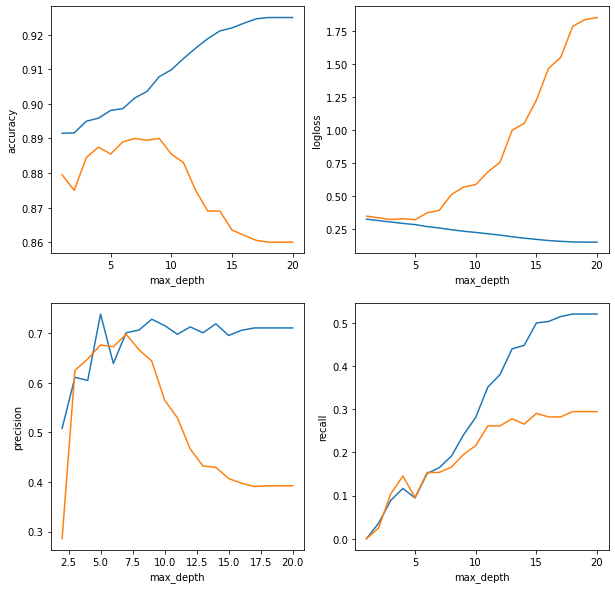

In [278]:
impurity_weights = [1, 1]
_range = range(1, 21)
target = 'max_depth'

errors = find_best_param(impurity_weights, train_data, train_labels, test_data, test_labels, _range, target)
show_err_plots(_range, target, errors)

1. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 1), ('threshold', 0.5), ('impurity_weights', [1, 10]), ('_tree', None)]


<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])


          y=1   y=0
y_pred=1    0     0
y_pred=0  868  7132
          y=1   y=0
y_pred=1    0     0
y_pred=0  241  1759

2. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 2), ('threshold', 0.5), ('impurity_weights', [1, 10]), ('_tree', None)]
          y=1   y=0
y_pred=1   31    30
y_pred=0  837  7102
          y=1   y=0
y_pred=1    6    15
y_pred=0  235  1744

3. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 3), ('threshold', 0.5), ('impurity_weights', [1, 10]), ('_tree', None)]
          y=1   y=0
y_pred=1   77    49
y_pred=0  791  7083
          y=1   y=0
y_pred=1   25    15
y_pred=0  216  1744

4. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 4), ('threshold', 0.5), ('impurity_weights', [1, 10]), ('_tree', None)]
          y=1   y=0
y_pred=1  101    66
y_pred=0  767  7066
          y=1   y=0
y_pred=1   35    19
y_pred=0  206  1740

5. Target: max_depth. Tree params: [('min_leaf', 5), ('max_depth', 5), ('threshold', 0.5), ('impuri

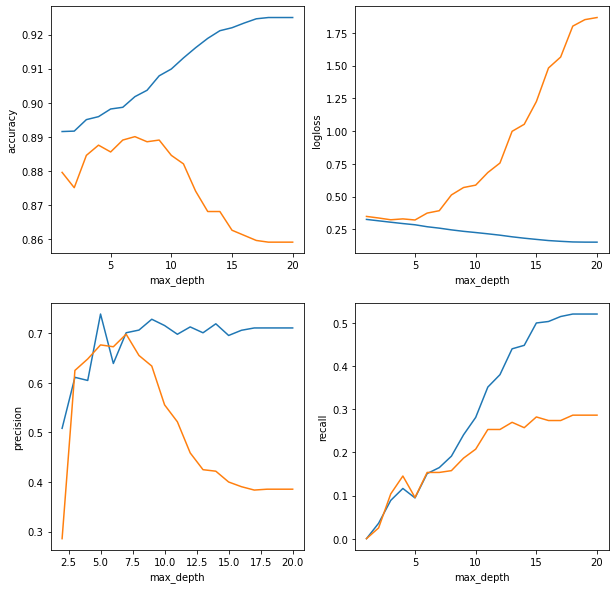

In [279]:
impurity_weights = [1, 10]
_range = range(1, 21)
target = 'max_depth'

errors = find_best_param(impurity_weights, train_data, train_labels, test_data, test_labels, _range, target)
show_err_plots(_range, target, errors)

1. Target: max_depth. Tree params: [('criterion', 'gini'), ('splitter', 'best'), ('max_depth', 1), ('min_samples_split', 2), ('min_samples_leaf', 1), ('min_weight_fraction_leaf', 0.0), ('max_features', None), ('max_leaf_nodes', None), ('random_state', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('class_weight', None), ('presort', 'deprecated'), ('ccp_alpha', 0.0)]
          y=1   y=0
y_pred=1    0     0
y_pred=0  868  7132
          y=1   y=0
y_pred=1    0     0
y_pred=0  241  1759

2. Target: max_depth. Tree params: [('criterion', 'gini'), ('splitter', 'best'), ('max_depth', 2), ('min_samples_split', 2), ('min_samples_leaf', 1), ('min_weight_fraction_leaf', 0.0), ('max_features', None), ('max_leaf_nodes', None), ('random_state', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('class_weight', None), ('presort', 'deprecated'), ('ccp_alpha', 0.0)]
          y=1   y=0
y_pred=1   31    30
y_pred=0  837  7102
          y=1   y=0
y_pred=1    6  

<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])


          y=1   y=0
y_pred=1   34    19
y_pred=0  207  1740

5. Target: max_depth. Tree params: [('criterion', 'gini'), ('splitter', 'best'), ('max_depth', 5), ('min_samples_split', 2), ('min_samples_leaf', 1), ('min_weight_fraction_leaf', 0.0), ('max_features', None), ('max_leaf_nodes', None), ('random_state', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('class_weight', None), ('presort', 'deprecated'), ('ccp_alpha', 0.0)]
          y=1   y=0
y_pred=1   80    23
y_pred=0  788  7109
          y=1   y=0
y_pred=1   22    12
y_pred=0  219  1747

6. Target: max_depth. Tree params: [('criterion', 'gini'), ('splitter', 'best'), ('max_depth', 6), ('min_samples_split', 2), ('min_samples_leaf', 1), ('min_weight_fraction_leaf', 0.0), ('max_features', None), ('max_leaf_nodes', None), ('random_state', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('class_weight', None), ('presort', 'deprecated'), ('ccp_alpha', 0.0)]
          y=1   y=0
y_pred=1  130 

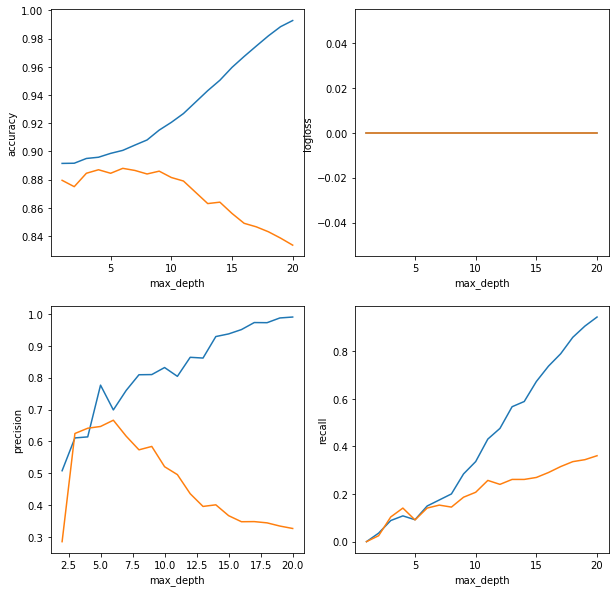

In [291]:
impurity_weights = [1, 10]
_range = range(1, 21)
target = 'max_depth'

errors = find_best_param_sklearn(train_data, train_labels, test_data, test_labels, _range, target)
show_err_plots(_range, target, errors)

<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])


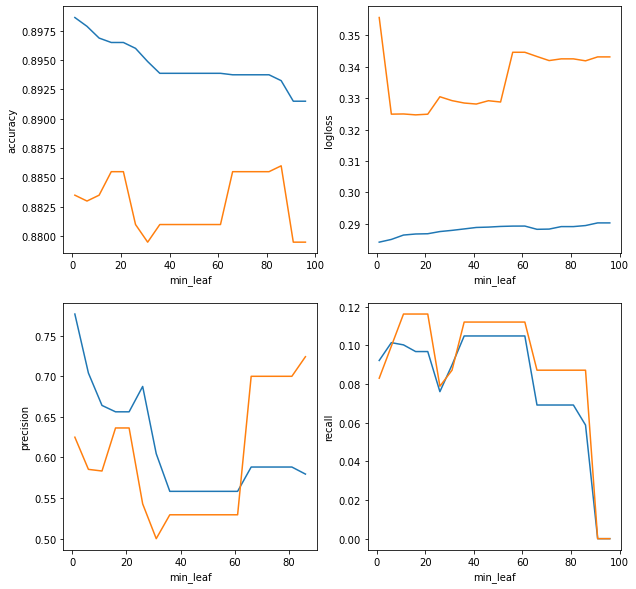

In [267]:
impurity_weights = [1, 1]
_range = range(1, 101, 5)
target = 'min_leaf'

errors = find_best_param(impurity_weights, train_data, train_labels, test_data, test_labels, _range, target)
show_err_plots(_range, target, errors)

1. Target: min_leaf. Tree params: [('criterion', 'gini'), ('splitter', 'best'), ('max_depth', 5), ('min_samples_split', 2), ('min_samples_leaf', 1), ('min_weight_fraction_leaf', 0.0), ('max_features', None), ('max_leaf_nodes', None), ('random_state', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('class_weight', None), ('presort', 'deprecated'), ('ccp_alpha', 0.0)]
          y=1   y=0
y_pred=1   80    23
y_pred=0  788  7109
          y=1   y=0
y_pred=1   22    12
y_pred=0  219  1747

6. Target: min_leaf. Tree params: [('criterion', 'gini'), ('splitter', 'best'), ('max_depth', 5), ('min_samples_split', 2), ('min_samples_leaf', 6), ('min_weight_fraction_leaf', 0.0), ('max_features', None), ('max_leaf_nodes', None), ('random_state', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('class_weight', None), ('presort', 'deprecated'), ('ccp_alpha', 0.0)]
          y=1   y=0
y_pred=1   83    32
y_pred=0  785  7100
          y=1   y=0
y_pred=1   24    

<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])
<ipython-input-6-d015464f4d4b>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=0'][0])


          y=1   y=0
y_pred=1    0     0
y_pred=0  868  7132
          y=1   y=0
y_pred=1    0     0
y_pred=0  241  1759



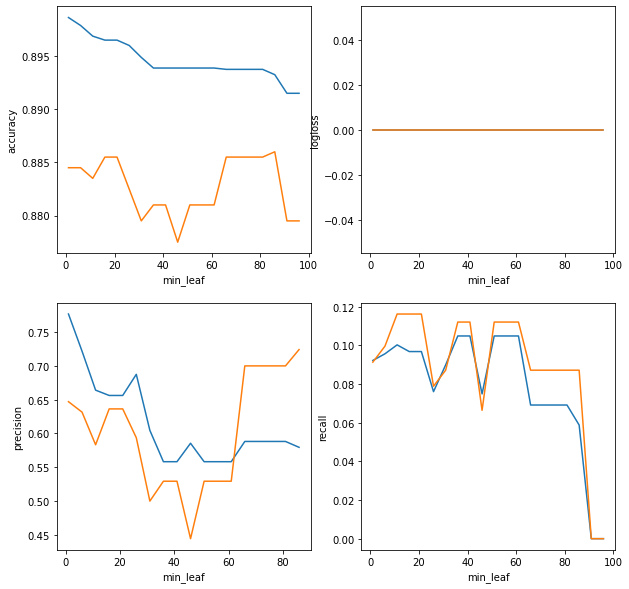

In [292]:
impurity_weights = [1, 10]
_range = range(1, 101, 5)
target = 'min_leaf'

errors = find_best_param_sklearn(train_data, train_labels, test_data, test_labels, _range, target)
show_err_plots(_range, target, errors)

***
Видим, что на test выборке у нас accuracy хуже, чем если предсказать все нули. Метрику logloss тяжело интерпретировать, но у нее тоже завышенные, относительно возможных, показатели  

Выведу матрицу ошибок, скорее всего дерево предиктит ответы в сторону "точности", а не "полноты", если это так, то модель имеет смысл быть
***

In [59]:
tree = DTC(min_leaf=17, max_depth=2)
tree.fit(train_data, train_labels)
predictions = tree.predict(test_data)
predictions = np.array(predictions)

In [60]:
conf_matrix = confusion_matrix(test_labels, predictions)
print(f'{conf_matrix}\n\n'
      f'precision: {calc_precision(conf_matrix)}\n'
      f'recall: {calc_recall(conf_matrix)}')

          y=1   y=0
y_pred=1   50    40
y_pred=0  191  1719

precision: 0.5555555555555556
recall: 0.2074688796680498


In [306]:
tree2 = DecisionTreeClassifier(min_samples_leaf=17, max_depth=5, class_weight={0:1.0, 1: 3.0})
tree2.fit(train_data, train_labels)
predictions2 = tree2.predict(test_data)
predictions2 = np.array(predictions2)

In [307]:
conf_matrix = confusion_matrix(test_labels, predictions2)
print(f'{conf_matrix}\n\n'
      f'precision: {calc_precision(conf_matrix)}\n'
      f'recall: {calc_recall(conf_matrix)}')

          y=1   y=0
y_pred=1   98   164
y_pred=0  143  1595

precision: 0.37404580152671757
recall: 0.4066390041493776


***
Как видно, у нас беда с precision/recall, мы предсказываем слишком много нулей и очень плохо предсказываем класс единиц

Попробуем разделить данные другим путем. Оставим одинаковое кол-во как образцов класса 1, так и образцов класса 0
***

In [30]:
np.random.seed(42)

df_class_1_idx = np.random.choice((df.loc[df['choose'] == 1].index), 1000)
df_class_0_idx = np.random.choice((df.loc[df['choose'] == 0].index), 1000)
df_balanced = df.iloc[df_class_1_idx].reset_index()
df_balanced = df_balanced.append(df.iloc[df_class_0_idx], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index().drop(['index', 'level_0'], axis=1)
df_balanced['choose'].value_counts()

1    1000
0    1000
Name: choose, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced.loc[:, 'age':'mean_exam_points'],
                                                                    df_balanced['choose'],
                                                                    test_size = 0.2,
                                                                    random_state=42)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

**Подбираем параметры для дерева решений**

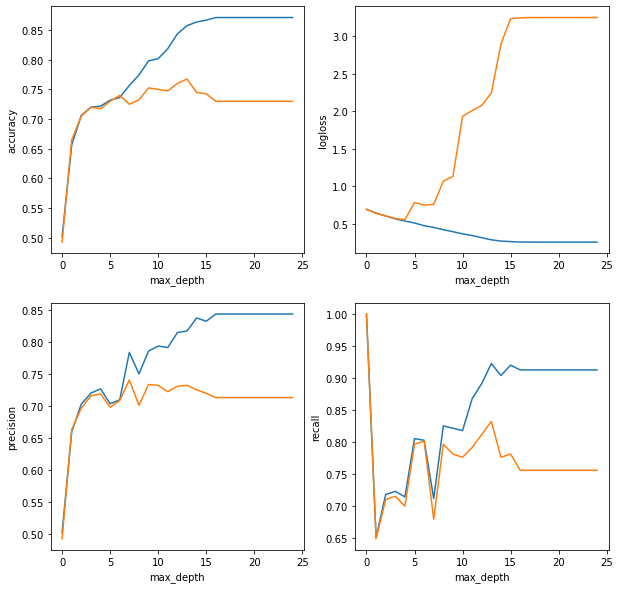

In [95]:
_range = range(25)
target = 'max_depth'

errors = find_best_param(X_train, y_train, X_test, y_test, _range, target)
show_err_plots(_range, target, errors)

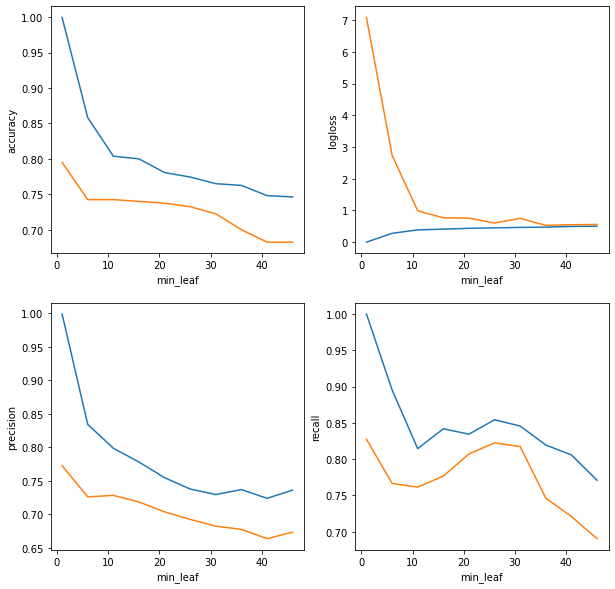

In [96]:
_range = range(1, 51, 5)
target = 'min_leaf'

errors = find_best_param(X_train, y_train, X_test, y_test, _range, target)
show_err_plots(_range, target, errors)

**Смотрим результаты модели**

In [97]:
tree = DTC(min_leaf=20, max_depth=4)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
predictions = np.array(predictions)

In [98]:
# на тренировочных данных
conf_matrix = confusion_matrix(y_test, predictions)
print(f'{conf_matrix}\n\n'
      f'precision: {calc_precision(conf_matrix)}\n'
      f'recall: {calc_recall(conf_matrix)}')

          y=1  y=0
y_pred=1  140   56
y_pred=0   57  147

precision: 0.7142857142857143
recall: 0.7106598984771574


In [99]:
# на тестовых данных
test_predictions = tree.predict(test_data)
test_predictions = np.array(test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print(f'{conf_matrix}\n\n'
      f'precision: {calc_precision(conf_matrix)}\n'
      f'recall: {calc_recall(conf_matrix)}')

          y=1   y=0
y_pred=1  175   555
y_pred=0   66  1204

precision: 0.23972602739726026
recall: 0.7261410788381742


In [100]:
# на других тестовых данных
train_predictions = tree.predict(train_data)
train_predictions = np.array(train_predictions)
conf_matrix = confusion_matrix(train_labels, train_predictions)
print(f'{conf_matrix}\n\n'
      f'precision: {calc_precision(conf_matrix)}\n'
      f'recall: {calc_recall(conf_matrix)}')

          y=1   y=0
y_pred=1  605  2071
y_pred=0  263  5061

precision: 0.22608370702541106
recall: 0.6970046082949308


In [101]:
pd.Series(train_predictions).value_counts()

0    5324
1    2676
dtype: int64

In [39]:
def threshold_iterator(train_data, train_labels, test_data, test_labels, _range):
    
    train_acc = []
    test_acc = []
    train_logloss = []
    test_logloss = []
    predictions = []
    
    for i in _range:
        tree = DTC(threshold=i)
        tree.fit(train_data, train_labels)
        train_acc.append(calc_accuracy(tree.predict(train_data), train_labels))
        predictions_tmp = tree.predict(test_data)
        predictions.append(predictions_tmp)
        test_acc.append(calc_accuracy(predictions_tmp, test_labels))
        train_logloss.append(calc_logloss(train_labels, tree.predict_proba(train_data)))
        test_logloss.append(calc_logloss(test_labels, tree.predict_proba(test_data)))
    
    return (train_acc, test_acc, train_logloss, test_logloss, predictions)

In [40]:
def roc_auc(y_test, predictions, _range):
    tpr_fpr = []
    for i, el in enumerate(_range):
        matrix = confusion_matrix(y_test, predictions[i])
        x = matrix['y=0'][0] / (matrix['y=0'][0] + matrix['y=0'][1])
        y = matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=1'][1])
        tpr_fpr.append((x, y))
    plt.plot(x, y)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [41]:
threshold_output = threshold_iterator(X_train, y_train, X_test, y_test, np.arange(0.02, 0.52, 0.02))

In [42]:
answers = np.array(threshold_output[4])

In [ ]:
answers

<ipython-input-209-eaa746f87c15>:6: RuntimeWarning: invalid value encountered in longlong_scalars
  x = matrix['y=0'][0] / (matrix['y=0'][0] + matrix['y=0'][1])
<ipython-input-209-eaa746f87c15>:7: RuntimeWarning: invalid value encountered in longlong_scalars
  y = matrix['y=1'][0] / (matrix['y=1'][0] + matrix['y=1'][1])


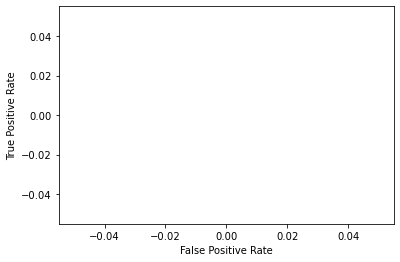

In [210]:
roc_auc(y_test, threshold_output[4], np.arange(0.02, 0.52, 0.02))

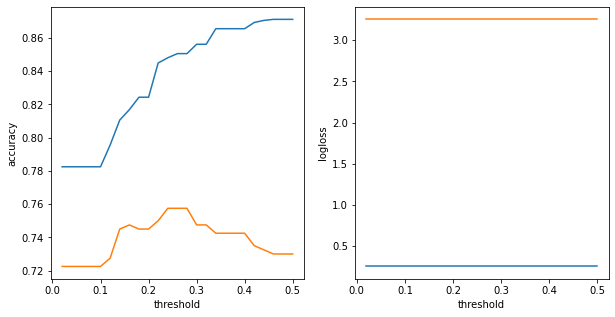

In [203]:
show_err_plots(np.arange(0.02, 0.52, 0.02), 'threshold', threshold_errors)

In [ ]:
# на тренировочных данных
conf_matrix = confusion_matrix(y_test, predictions)
print(f'{conf_matrix}\n\n'
      f'precision: {calc_precision(conf_matrix)}\n'
      f'recall: {calc_recall(conf_matrix)}')

In [ ]:
tree = DTC(min_leaf=17, max_depth=4)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
predictions = np.array(predictions)

***
Теперь модель стала предсказывать слишком много данных класса 1, меняем пропорцию данных в обратную сторону
***